## Set up

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
os.chdir('/content/drive/My Drive/Neural_Style')

## Import the Model

In [7]:
import tensorflow as tf
from tensorflow.python.keras.applications.vgg19 import VGG19
from PIL import Image

In [8]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'   
    ) 

# include_top은 상단의 F.C 레이어를 포함할 것인이 아닌지 결정하는 파라미터이다.
# weights='imagenet'으로 값을 주면 이미지넷으로 트레이닝 된 모델을 불러올 수 있다.

model.trainable = False # 레이어 고정


model.summary()

80142336/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

## Import Libraries and Helper Functions

In [9]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Image Processing and Display

In [10]:
def load_and_process_image(image_path):
  img = load_img(image_path)
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img, axis = 0) # 3D → 4D tensor로 만들기
  return img

In [11]:
def deprocess(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x 

def display_image(image):
  if len(image.shape) == 4:
    img = np.squeeze(image, axis = 0) # 4D → 3D
    
    img = deprocess(img)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return 

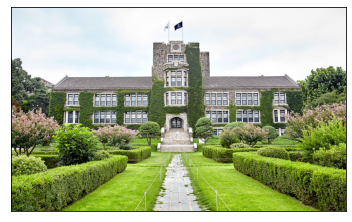

In [13]:
display_image(load_and_process_image('content1.jpg'))

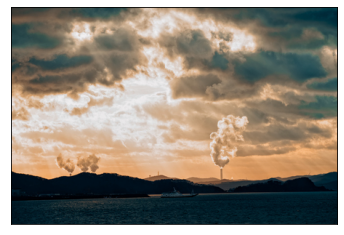

In [22]:
display_image(load_and_process_image('style1.jpg'))

## Content and Style Models

In [15]:
content_layer = 'block5_conv2'

style_layers = ['block1_conv1', 
                'block3_conv1', 
                'block5_conv1']

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                      outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [16]:
def content_cost(content, generated):
  a_C = content_model(content)
  a_G = content_model(generated)
  cost = tf.reduce_mean(tf.square(a_C - a_G)) # MSE: content와 generated 이미지가 얼마나 가까운가?
  return cost

## Gram Matrix

In [17]:
def gram_matrix(A):
  n_C = int(A.shape[-1])
  a = tf.reshape(A, [-1, n_C]) #200*200*3 → 200*3
  n = tf.shape(a)[0]
  G = tf.matmul(a, a, transpose_a = True)
  return G / tf.cast(n, tf.float32)

## Style Cost

In [18]:
lam = 1. / len(style_models)

def style_cost(style, generated):
  J_style = 0

  for style_model in style_models:
    a_S = style_model(style)
    a_G = style_model(generated)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    current_cost = tf.reduce_mean(tf.square(GS - GG)) # MSE: style과 generated 이미지가 얼마나 가까운가?
    J_style += current_cost * lam
  
  return J_style

## Training Loop

In [19]:
import time
generated_images = []

def training_loop(content_path, style_path, iteration = 20,
                  alpha = 10., beta = 20.):
  content = load_and_process_image(content_path)
  style = load_and_process_image(style_path)

  generated = tf.Variable(content, dtype = tf.float32)
  opt = tf.optimizers.Adam(learning_rate = 7.)

  best_cost = 1e12 + 0.1
  best_image = None

  start_time = time.time()
  
  for i in range(iteration):
    with tf.GradientTape() as tape:
      J_content = content_cost(content, generated)
      J_style = style_cost(style, generated)
      J_total = alpha * J_content + beta * J_style
    
    grads = tape.gradient(J_total, generated)
    opt.apply_gradients([(grads, generated)])

    if J_total < best_cost:
      best_cost = J_total
      best_image = generated.numpy()
      
    print('Cost at {}: {}. Time elapsed {}'.format(i, J_total, time.time() - start_time))
    generated_images.append(generated.numpy())

  return best_image

In [23]:
best_image = training_loop('content1.jpg', 'style1.jpg')

Cost at 0: 6707056128.0. Time elapsed 1.5176103115081787
Cost at 1: 3565307136.0. Time elapsed 2.6012210845947266
Cost at 2: 2218700800.0. Time elapsed 3.682262420654297
Cost at 3: 1550833536.0. Time elapsed 4.764177083969116
Cost at 4: 1175270016.0. Time elapsed 5.847157955169678
Cost at 5: 944569024.0. Time elapsed 6.932491064071655
Cost at 6: 793234240.0. Time elapsed 8.016721963882446
Cost at 7: 688043264.0. Time elapsed 9.102100372314453
Cost at 8: 610486720.0. Time elapsed 10.185533285140991
Cost at 9: 549244352.0. Time elapsed 11.267280340194702
Cost at 10: 497634272.0. Time elapsed 12.35600996017456
Cost at 11: 452352672.0. Time elapsed 13.440593242645264
Cost at 12: 411777408.0. Time elapsed 14.52480149269104
Cost at 13: 375086464.0. Time elapsed 15.606616258621216
Cost at 14: 342068224.0. Time elapsed 16.68873906135559
Cost at 15: 312430176.0. Time elapsed 17.77266812324524
Cost at 16: 286057312.0. Time elapsed 18.856631755828857
Cost at 17: 262499168.0. Time elapsed 19.93796

## Plot the Results

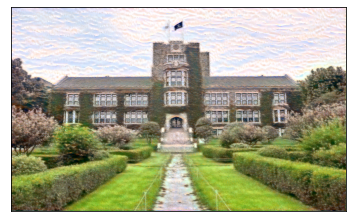

In [24]:
display_image(best_image)

## Video
#### 1) 원본 비디오를 개별 프레임으로 나누기

In [ ]:
import cv2
 
def video2frame(invideofilename, save_path):
    vidcap = cv2.VideoCapture(invideofilename)
    count = 0
    while True:
      success,image = vidcap.read()
      if not success:
          break
      print ('Read a new frame: ', success)
      fname = "{}.jpg".format("{0:05d}".format(count))
      cv2.imwrite(save_path + fname, image) # save frame as JPEG file
      count += 1
    print("{} images are extracted in {}.". format(count, save_path))

In [ ]:
# video2frame("paris.mp4", "./data/")

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

#### 2) 개별 프레임에 Neural Style 적용하기

In [ ]:
for i in range(312):
  fname = "{}.jpg".format("{0:05d}".format(i))
  data = './data/' + fname
  best_image = training_loop(data, 'style.jpg')
  output = './output/' + fname
  img = np.squeeze(best_image, axis = 0)
  img = deprocess(img)
  img = Image.fromarray(img, 'RGB')
  img.save(output)

Cost at 0: 9803660288.0. Time elapsed 0.34154272079467773
Cost at 1: 6424536064.0. Time elapsed 0.6701414585113525
Cost at 2: 3443369984.0. Time elapsed 0.9972867965698242
Cost at 3: 2673814272.0. Time elapsed 1.3250889778137207
Cost at 4: 1981212160.0. Time elapsed 1.652388334274292
Cost at 5: 1257690240.0. Time elapsed 1.9791560173034668
Cost at 6: 1002190656.0. Time elapsed 2.3063547611236572
Cost at 7: 973035392.0. Time elapsed 2.6339056491851807
Cost at 8: 939772864.0. Time elapsed 2.961491823196411
Cost at 9: 871378624.0. Time elapsed 3.2884864807128906
Cost at 10: 773443328.0. Time elapsed 3.6158132553100586
Cost at 11: 666047872.0. Time elapsed 3.9434444904327393
Cost at 12: 571656960.0. Time elapsed 4.2705066204071045
Cost at 13: 497300800.0. Time elapsed 4.59745454788208
Cost at 14: 438580160.0. Time elapsed 4.925742864608765
Cost at 15: 388969024.0. Time elapsed 5.2577855587005615
Cost at 16: 345186240.0. Time elapsed 5.585122585296631
Cost at 17: 305686272.0. Time elapsed 5

#### 3) 개별 프레임을 비디오로 합치기

In [ ]:
from os.path import isfile, join
pathIn= './ouput/'
pathOut = 'video.avi'

fps = 30

frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()